This part is responsible for generating data from full 3-Body Finite-Difference Simulations and storing it into CSV files

In [10]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import csv

In [11]:
# This function generates random initial positions and velocities of the three masses
# in x-y coordinates (i.e. x and y positions and velocities for each mass = 12 variables)
# All variables are initially drawn from a N(0,1) distribution with the positions and
# velocities in both directions shifted to zero. This ensures that one remains in the 
# "center of mass frame" and the data remains bounded without loss of generality

# function has no inputs and outputs positions x and velovities v [both with shape = (6,1)]

def gen_rand_xv():
    x = np.random.rand(6)
    (mx, my) = (np.mean([x[0], x[2], x[4]]), np.mean([x[1], x[3], x[5]])) 
    (x[0], x[2], x[4]) = (x[0]-mx, x[2]-mx, x[4]-mx)
    (x[1], x[3], x[5]) = (x[1]-my, x[3]-my, x[5]-my)

    v = 2*np.random.rand(6)
    (mvx, mvy) = (np.mean([v[0], v[2], v[4]]), np.mean([v[1], v[3], v[5]])) 
    (v[0], v[2], v[4]) = (v[0]-mvx, v[2]-mvx, v[4]-mvx)
    (v[1], v[3], v[5]) = (v[1]-mvy, v[3]-mvy, v[5]-mvy)
    return x, v

In [12]:
# This functions updates the velocities and positions of the masses according to the 
# force equation for the force between masses 1 and 2: $F_{1,2}=g/d(1,2)^2$ where d(1,2),
# where d(1,2) represents the distance between the masses

# function takes in initial position vector x, velocity vector v, attractive force magnitude g, and time step dt
# function outputs altered x and v after mutual attraction of masses during time step dt

def update_phase_space(x, v, g, dt):
    eps = 0.001
    dx12 = x[2]-x[0]
    dx13 = x[4]-x[0]
    dx23 = x[4]-x[2]
    dy12 = x[3]-x[1]
    dy13 = x[5]-x[1]
    dy23 = x[5]-x[3]
    
    d12sq = (dx12**2 + dy12**2 + eps)**(3/2)
    d13sq = (dx13**2 + dy13**2 + eps)**(3/2)  
    d23sq = (dx23**2 + dy23**2 + eps)**(3/2)
    
    a_1_x = dx12/d12sq + dx13/d13sq  
    a_1_y = dy12/d12sq + dy13/d13sq
    
    a_2_x = -dx12/d12sq + dx23/d23sq 
    a_2_y = -dy12/d12sq + dy23/d23sq
    
    a_3_x = -dx13/d13sq + -dx23/d23sq  
    a_3_y = -dy13/d13sq + -dy23/d23sq
    
    a = g*np.array([a_1_x, a_1_y, a_2_x, a_2_y, a_3_x, a_3_y])
    vn = dt*a+v
    xn = dt**2*a + dt*v + x
    return xn, vn

In [13]:
# This function creates a full trajectory of the masses given initial conditions,
# a time step, and a number of simulated time steps. This is the full finite-difference
# calculation that the machine learning task seeks to expedite

# function takes in initial position vector x0, velocity vector v0, attractive force magnitude g,
# time step dt, and number of time steps t_steps
# function outputs log of positions and velocities for each time step [res_x and res_v with shape = (t_steps, 6)]

def create_trajectory(x0, v0, g, dt, t_steps):
    res_x = np.zeros((t_steps, 6))
    res_v = np.zeros((t_steps, 6))
    res_x[0,:] = x0 
    res_v[0,:] = v0
    for i in range(1,t_steps):
        (xn, vn) = update_phase_space(res_x[i-1,:], res_v[i-1,:], g, dt)
        res_x[i,:] = xn
        res_v[i,:] = vn
    return res_x, res_v

In [14]:
# This functions generates random initial conditions, finds the final conditions 
# after some number of time steps, and outputs both as input and output data for training/testing

# function takes in attractive force magnitude g, time step dt, and number of time steps t_steps
# function outputs the initial positions and velocities X and final ones Y [both of shape = (12,1)]

def gen_X_Y(g, dt, t_steps):
    (x, v) = gen_rand_xv()
    (res_x, res_v) = create_trajectory(x, v, g, dt, t_steps)
    X = np.hstack((res_x[0], res_v[0]))
    Y = np.hstack((res_x[-1], res_v[-1]))
    return X, Y

In [15]:
# This function plots random trajectories for the purposes of testing and visualization
# Initial points are shown in red and final ones in black

# function takes in attractive force magnitude g, time step dt, and number of time steps t_steps
# function does not output anything but shows trajectory plot

def plot_traj(g, dt, t_steps):
    (X, Y) = gen_X_Y(g, dt, t_steps)
    (res_x, res_v) = create_trajectory(X[0:6], X[6:12], g, dt, t_steps)
    
    plt.plot([X[0],X[2],X[4]],[X[1], X[3], X[5]],'ro')
    plt.plot(res_x[:,0], res_x[:,1])
    plt.plot(res_x[:,2], res_x[:,3])
    plt.plot(res_x[:,4], res_x[:,5])
    plt.plot([Y[0],Y[2],Y[4]],[Y[1], Y[3], Y[5]],'ko')
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.title('Chaotic Trajectories of Three Mutually-Attracting Masses')
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.show()

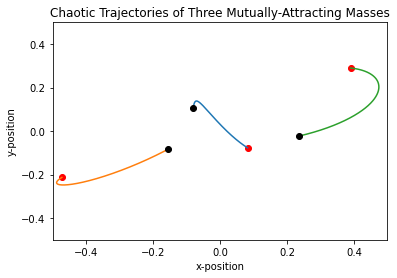

In [16]:
plot_traj(1, 0.001, 500)

In [17]:
# Generates .csv file with non-augmented (X,Y) data combined in rows
# and m columns with different randomized instances


# function takes in attractive force magnitude g, time step dt, number of time steps t_steps, and number of examples m
# function has no output but writes data to a .csv file

def gen_data_file(g, dt, t_steps, m):
    name = 'data_m-'+str(m)+'_g-'+str(g)+'dt-'+str(dt)[2:]+'ts-'+str(t_steps)+'.csv'
    print(name)
    wtr = csv.writer(open (name, 'w'), delimiter=',', lineterminator='\n')
    for i in range(m+1):
        (X, Y) = gen_X_Y(1, .001, 500)
        wtr.writerow (np.hstack((X, Y)))

In [19]:
gen_data_file(1, 0.001, 500, 20000)

data_m-20000_g-1dt-001ts-500.csv


In [ ]:
wtr = csv.writer(open ('data_2000_s_1_001_500.csv', 'w'), delimiter=',', lineterminator='\n')
for i in range(2000):
    (X, Y) = gen_X_Y(1, .001, 500)
    wtr.writerow (np.hstack((X, Y)))

In [777]:
(X, Y) = gen_X_Y(1, .001, 500)
print(np.hstack((X, Y)))

[ 0.06608546  0.37041265  0.0197359  -0.09640853 -0.08582136 -0.27400412
  0.11871317 -0.64728521  0.61143729 -0.2862211  -0.73015047  0.93350631]
[ 0.09159493 -0.19343276  0.14634286 -0.01763007 -0.23793779  0.21106283
 -1.47577195  0.77024721  1.07136201 -0.56084112  0.40440993 -0.20940609]
[ 0.06608546  0.37041265  0.0197359  -0.09640853 -0.08582136 -0.27400412
  0.11871317 -0.64728521  0.61143729 -0.2862211  -0.73015047  0.93350631
  0.09159493 -0.19343276  0.14634286 -0.01763007 -0.23793779  0.21106283
 -1.47577195  0.77024721  1.07136201 -0.56084112  0.40440993 -0.20940609]


Text(0,0.5,'y-position')

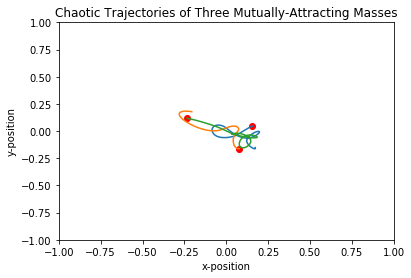

In [770]:
(x, v) = gen_rand_xv()
(res_x, res_v) = create_trajectory(x, v, 1, .001, 500)

plt.plot([res_x[0,0],res_x[0,2],res_x[0,4]],[res_x[0,1], res_x[0,3], res_x[0,5]],'ro')
plt.plot(res_x[:,0], res_x[:,1])
plt.plot(res_x[:,2], res_x[:,3])
plt.plot(res_x[:,4], res_x[:,5])
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Chaotic Trajectories of Three Mutually-Attracting Masses')
plt.xlabel('x-position')
plt.ylabel('y-position')

In [ ]:
# code below tests that data taken is consistent

In [865]:
import pandas as pd
data = pd.read_csv("data_m-2000_g-1dt-001ts-500.csv", nrows=1)
data = [float(i) for i in list(data)]

In [866]:
print(data)

[0.2626968562067743, -0.3935497766596279, -0.3448832089109518, -0.15600759518040536, 0.0821863527041774, 0.5495573718400331, 0.9419818531461838, 0.5969887780546463, -0.45394623184433736, -1.0751938959785734, -0.48803562130184674, 0.4782051179239273, 0.4651753731550059, 0.03274878441093864, -0.308323466708136, -0.5740752235969815, -0.15685190644687044, 0.541326439186042, -0.08685063654680147, 0.9948459646442117, 0.4309434577865309, -0.526306764119846, -0.3440928212397296, -0.46853920052436493]


Text(0,0.5,'y-position')

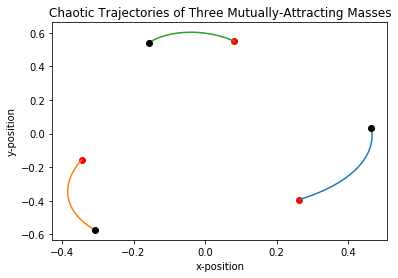

In [867]:
(res_x, res_v) = create_trajectory(data[0:6], data[6:12], 1, .001, 500)

plt.plot([res_x[0,0],res_x[0,2],res_x[0,4]],[res_x[0,1], res_x[0,3], res_x[0,5]],'ro')
plt.plot(res_x[:,0], res_x[:,1])
plt.plot(res_x[:,2], res_x[:,3])
plt.plot(res_x[:,4], res_x[:,5])
plt.plot([data[12],data[14],data[16]],[data[13],data[15],data[17]],'ko')
#plt.xlim([-1,1])
#plt.ylim([-1,1])
plt.title('Chaotic Trajectories of Three Mutually-Attracting Masses')
plt.xlabel('x-position')
plt.ylabel('y-position')